# ASR Dataset Quality Evaluation

Manual quality check of 100 randomly sampled transcriptions from the [dataset](https://huggingface.co/datasets/islomov/news_youtube_uzbek_speech_dataset). 
Evaluated Word Error Rate (WER), Character Error Rate (CER), and foreign language contamination.

**Methodology:**
1. Randomly sampled 100 audio files from the dataset
2. Extracted audio from parquet files using sample IDs
3. Manually verified and corrected transcriptions using custom HTML checker tool
4. Computed WER/CER metrics and foreign words count

In [1]:
import gc  # Garbage collector
import glob
import io
import os

import pandas as pd
import soundfile as sf
from tqdm import tqdm  # Progress bar library

SEED = 137
DATASET_DIR = "../datasets/news_youtube_uzbek_speech_dataset/data"
SAMPLED_AUDIO_DIR = os.path.join(DATASET_DIR, "sampled_audio")
CHUNKED_AUDIO_DIR = os.path.join(DATASET_DIR, "chunked_audio")

ALL_DATA_PATH = os.path.join(DATASET_DIR, "dataset.csv")
SAMPLED_DATA_PATH = os.path.join(DATASET_DIR, "sampled.csv")
PROCESSED_AUDIO_STATS_PATH = os.path.join(DATASET_DIR, "processed_audio_stats.csv")
TRANSCRIPTION_RESULTS_PATH = os.path.join(DATASET_DIR, "google_spt_transcriptions.csv")
VALIDATION_TEST_SETS_PATH = os.path.join(DATASET_DIR, "validation_test_sets.csv")

SAMPLED_DATA2_PATH = os.path.join(DATASET_DIR, "sampled2.csv")

### Create csv file with all data and computed statistics

In [2]:
def compute_statistics(df: pd.DataFrame, ignore_sampling_rate=True) -> dict:
    """Extract statistics without keeping audio in memory"""
    stats = {
        "id": [],
        "text_original": [],
        "path": [],
        "duration": [],
        "char_count": [],
        "word_count": [],
    }
    if not ignore_sampling_rate:
        stats["sampling_rate"] = []

    for i in range(len(df)):
        # Extract metadata
        stats["id"].append(df.iloc[i]["id"])
        stats["path"].append(df.iloc[i]["audio"]["path"])

        text = df.iloc[i]["text"]
        stats["text_original"].append(text)

        # Decode audio
        audio_bytes = df.iloc[i]["audio"]["bytes"]
        audio_array, sr = sf.read(io.BytesIO(audio_bytes))

        duration = len(audio_array) / sr
        stats["duration"].append(duration)
        stats["char_count"].append(len(text))
        stats["word_count"].append(len(text.split()))
        if not ignore_sampling_rate:
            stats["sampling_rate"].append(sr)

        # Clear audio from memory immediately
        del audio_bytes, audio_array

    return stats


parquet_files = glob.glob(f"{DATASET_DIR}/*.parquet")
num_parquets = len(parquet_files)

if num_parquets == 0:
    raise FileNotFoundError(f"No parquet files found. Exiting...")

print(f"Found {num_parquets} parquet files. Started processing...\n")

all_data = []
for parquet_file_path in tqdm(parquet_files, desc="Processing files"):
    df_partial = pd.read_parquet(parquet_file_path)

    stats = compute_statistics(df_partial)
    all_data.append(pd.DataFrame(stats))

    # Explicitly delete the dataframe with heavy audio bytes
    del df_partial
    gc.collect()

# Combine all data
df = pd.concat(all_data, ignore_index=True)
del all_data  # Free memory
gc.collect()

df["id"] = df["id"].astype(int)
df.set_index("id", inplace=True)
df.to_csv(ALL_DATA_PATH)

Found 34 parquet files. Started processing...



Processing files: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]


In [3]:
df = pd.read_csv(ALL_DATA_PATH, index_col="id")

print(df.info())
print(df.describe())
print("\nFirst few rows:")
df

<class 'pandas.core.frame.DataFrame'>
Index: 20795 entries, 4285 to 19573
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   text_original  20795 non-null  object 
 1   path           20795 non-null  object 
 2   duration       20795 non-null  float64
 3   char_count     20795 non-null  int64  
 4   word_count     20795 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 974.8+ KB
None
           duration    char_count    word_count
count  20795.000000  20795.000000  20795.000000
mean      25.872685    358.585814     45.937725
std        5.792185    117.732594     15.300639
min        3.013500      8.000000      1.000000
25%       23.877375    291.000000     37.000000
50%       28.709375    378.000000     48.000000
75%       30.000000    443.000000     56.000000
max       30.000062    690.000000     97.000000

First few rows:


,text_original,path,duration,char_count,word_count
id,,,,,
4285,Chiqqandan keyingi rejalarni o'ylab qolganmisi...,00004285.wav,28.518875,425,57
4286,Qoʻchqor Oʻlmas Ismoilovichga Oʻzbekiston Resp...,00004286.wav,25.904000,351,38
4287,Mulki Zulfiya Zayniddinovna nomiga rasmiylasht...,00004287.wav,15.152000,169,19
4288,Oxunov mahalla fuqarolar yig'ini hududida joyl...,00004288.wav,29.509375,331,41
4289,128 million 177 ming 500 soʻm pul hamda 2016-y...,00004289.wav,27.152000,188,28
...,...,...,...,...,...
19569,fikrni bildirdilar va ular mana shu Afgʻon mar...,00019569.wav,30.000000,342,39
19570,Bu angar mana shu xalqaro transport logistik h...,00019570.wav,30.000000,270,34
19571,"Ismatilla Ergashevning maʼlum qilishicha, shu ...",00019571.wav,15.749313,210,23


### Dataset statistics plotted

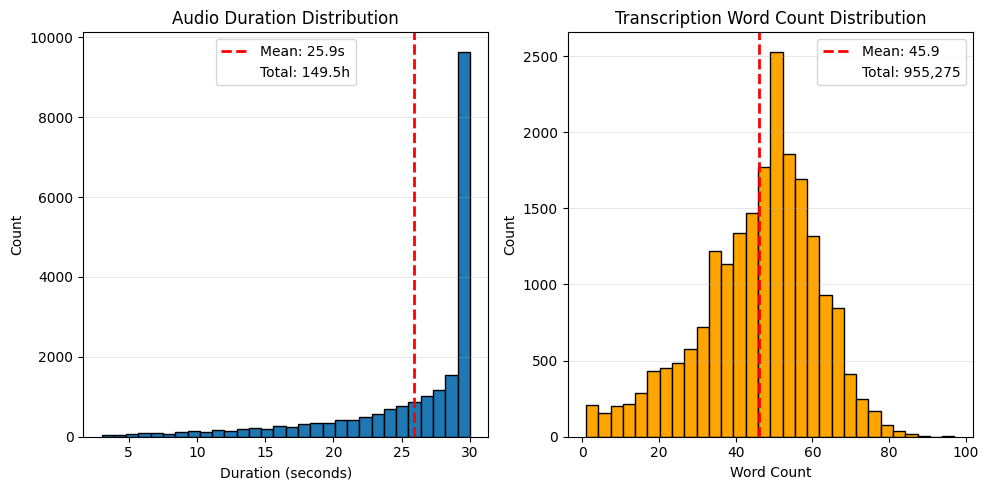

In [4]:
from scripts.dataset_plotting import plot_distribution_graphs

plot_distribution_graphs(df)

### Extract short random samples

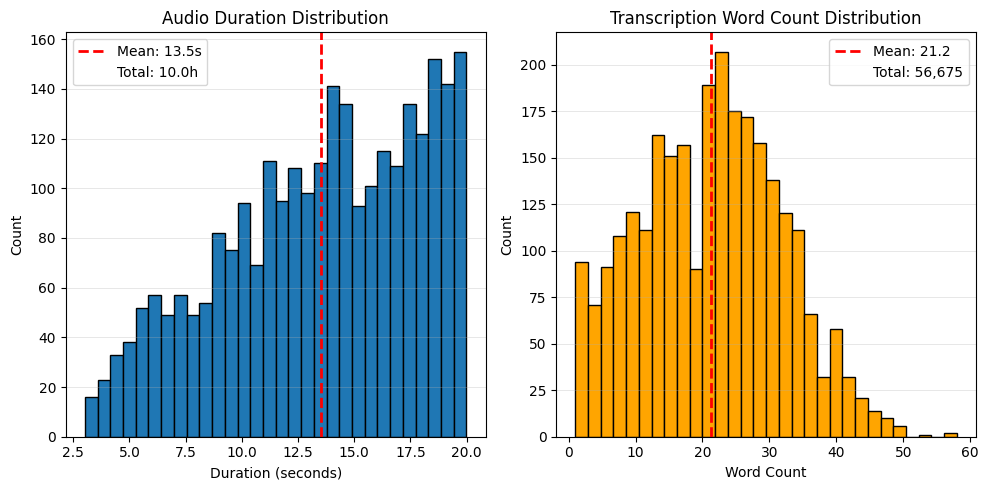

,text_original,path,duration,char_count,word_count
id,,,,,
4,Nimaga? Malayziyada yaxshi universitetlar bor....,00000004.wav,17.285312,273,37
7,ikkita founder bitta kompaniyada ishlagan payt...,00000007.wav,8.464000,98,13
20,va oʻrningizga mutaxassis topilmayapti. Misol ...,00000020.wav,16.442688,282,38
35,"va boshida u kompaniyaga asos solmagan, oddiy ...",00000035.wav,18.512000,324,41
45,"shu narsaga dadam ahamiyat bergan. Bilimni, qa...",00000045.wav,19.130688,334,45
...,...,...,...,...,...
20775,"Yuqori Kengash, Respublika Ministrlar Kengashi...",00020775.wav,15.322688,196,23
20776,"xalq bilan gaplashdi, xalqqa koʻp narsalarni, ...",00020776.wav,7.280000,81,10
20778,"mana havas qilib, e, kelsa boʻlar ekan, Qoraqa...",00020778.wav,17.893375,186,24


In [5]:
medium_audios = (df["duration"] <= 15)
long_audios = (df["duration"] > 15) & (df["duration"] <= 20)

medium_samples = df[medium_audios]
long_random_samples = df[long_audios].sample(1100, random_state=SEED)

sampled_df = pd.concat([medium_samples, long_random_samples]).sort_index()
sampled_df.to_csv(SAMPLED_DATA_PATH, index_label="id")

plot_distribution_graphs(sampled_df)

sampled_df

### Extract audios from parquet files to manually check the quality of the overall dataset 

In [6]:
import scripts.audio_preprocessing as ap

sampled_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")

# Extract audios from parquet files
unused_ids = set(sampled_df.index.tolist())
print(f"Need to extract {len(unused_ids)} audio files")

# Create directory for extracted audio
os.makedirs(SAMPLED_AUDIO_DIR, exist_ok=True)

parquet_files = glob.glob(f"{DATASET_DIR}/*.parquet")
num_parquets = len(parquet_files)

if num_parquets == 0:
    raise FileNotFoundError(f"No parquet files found. Exiting...")

print(f"Found {num_parquets} parquet files. Started processing...\n")

stats = []
found_count = 0
for parquet_file_path in tqdm(parquet_files, desc="Processing files"):
    if found_count >= len(unused_ids):
        break

    df_partial = pd.read_parquet(parquet_file_path)
    df_partial["id"] = df_partial["id"].astype(int)
    df_partial.set_index("id", inplace=True)

    # Filter to only rows we need
    matching_rows = df_partial[df_partial.index.isin(unused_ids)]

    if len(matching_rows) < 1:
        del df_partial
        continue

    # Extract and normalize audios from parquet files
    audio_stats_partial_df = pd.DataFrame()
    for _, row in matching_rows.iterrows():
        audio_bytes = row["audio"]["bytes"]

        output_filename = row["audio"]["path"]
        output_path = os.path.join(SAMPLED_AUDIO_DIR, output_filename)

        waveform, stat = ap.process_audio_bytes(
            output_filename,
            audio_bytes,
            save_path=output_path,
            normalize=True,
            target_rms_db=-23.0,
            apply_highpass=True,
            highpass_cutoff=80.0,
            remove_silences=True,
            silence_threshold_db=-45.0,
            min_silence_duration=1.3
        )

        stats.append(stat)
        found_count += 1

    # Explicitly delete the dataframe with heavy audio bytes
    del df_partial
    gc.collect()

processed_audio_stats_df = pd.DataFrame(stats)
processed_audio_stats_df.to_csv(PROCESSED_AUDIO_STATS_PATH, index=False)

print(f"\nExtracted and normalized {found_count} audio files to {SAMPLED_AUDIO_DIR}")
processed_audio_stats_df

Need to extract 2668 audio files
Found 34 parquet files. Started processing...



Processing files: 100%|██████████| 34/34 [02:00<00:00,  3.55s/it]


Extracted and normalized 2668 audio files to ../datasets/news_youtube_uzbek_speech_dataset/data/sampled_audio


,input_audio_filename,original_rms_db,final_rms_db,original_duration,final_duration,reduced_duration,peak_amplitude,is_clipped
0,00004287.wav,-27.4685,-23.1002,15.152000,15.152000,0.0000,0.4516,False
1,00004295.wav,-25.7626,-23.1376,9.968000,9.968000,0.0000,0.5506,False
2,00004296.wav,-27.3637,-23.1122,18.405375,18.405375,0.0000,0.4079,False
3,00004303.wav,-24.0325,-23.1166,12.186687,12.186687,0.0000,0.4591,False
4,00004322.wav,-26.1551,-23.1065,14.629375,14.629375,0.0000,0.5394,False
...,...,...,...,...,...,...,...,...
2663,00019541.wav,-23.1250,-23.1175,5.493500,5.493500,0.0000,0.4816,False
2664,00019555.wav,-24.4751,-23.1585,13.072000,13.072000,0.0000,0.5557,False
2665,00019556.wav,-21.9904,-23.1593,18.821375,17.600000,1.2214,0.5599,False
2666,00019571.wav,-21.0641,-23.1049,15.749313,14.620000,1.1293,0.5790,False


In [7]:
processed_audio_stats_df.describe()

,original_rms_db,final_rms_db,original_duration,final_duration,reduced_duration,peak_amplitude
count,2668.000000,2668.000000,2668.000000,2668.000000,2668.000000,2668.000000
mean,-24.077418,-23.209940,13.519254,13.205623,0.313633,0.600199
std,3.851966,0.094251,4.364499,4.399066,0.923642,0.111716
min,-36.051800,-24.659800,3.013500,2.260000,0.000000,0.223900
25%,-26.892250,-23.243925,10.298687,9.968000,0.000000,0.527200
50%,-24.206950,-23.190400,14.010687,13.696031,0.000000,0.603250
75%,-21.307125,-23.151500,17.306687,16.924516,0.000000,0.674200
max,-12.033000,-23.047900,19.994688,19.994688,12.130000,0.896300


In [8]:
sampled_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")
processed_audio_stats_df = pd.read_csv(PROCESSED_AUDIO_STATS_PATH)

old_total_duration = sampled_df["duration"].sum() / 3600
old_duration_mean = sampled_df["duration"].mean()

# --- Replace sampled_df.duration using processed_audio_stats_df.final_duration ---

# Merge final_duration into the sampled dataframe
sampled_df = sampled_df.merge(
    processed_audio_stats_df[["input_audio_filename", "final_duration"]],
    how="left",
    left_on="path",
    right_on="input_audio_filename"
)

# Replace duration only where we have final_duration
sampled_df["duration"] = (
    sampled_df["final_duration"].combine_first(sampled_df["duration"])
)

# Drop helper columns
sampled_df = sampled_df.drop(columns=["final_duration"])

# --- Remove suspiciously short and short recordings  ---

# Remove very short audios
mask_short_audio = (processed_audio_stats_df["final_duration"] < 3)
paths_to_remove = processed_audio_stats_df.loc[mask_short_audio, "input_audio_filename"].tolist()

total_reduced_duration = processed_audio_stats_df["reduced_duration"].sum() / 3600

# Remove these rows from processed stats
processed_audio_stats_df = processed_audio_stats_df[
    ~processed_audio_stats_df["input_audio_filename"].isin(paths_to_remove)
]

# Remove these recordings entirely
sampled_df = sampled_df[
    ~sampled_df["path"].isin(paths_to_remove)
]
print(f"{len(paths_to_remove)} recordings are removed from the sample")

# Updated totals
current_total_duration = processed_audio_stats_df["final_duration"].sum() / 3600
current_duration_mean = processed_audio_stats_df["final_duration"].mean()

# Save updated CSVs
processed_audio_stats_df.to_csv(PROCESSED_AUDIO_STATS_PATH)
sampled_df.to_csv(SAMPLED_DATA_PATH, index_label="id")

print(
    f"Before audio preprocessing: total duration - {old_total_duration:,.3f} h | mean {old_duration_mean:,.1f} s"
)
print(
    f"After audio preprocessing: total duration - {current_total_duration:,.3f} h "
    f"(reduced {total_reduced_duration * 60:.0f} min) | mean {current_duration_mean:,.1f} s"
)

sampled_df

4 recordings are removed from the sample
Before audio preprocessing: total duration - 10.019 h | mean 13.5 s
After audio preprocessing: total duration - 9.784 h (reduced 14 min) | mean 13.2 s


,text_original,path,duration,char_count,word_count,input_audio_filename
0,Nimaga? Malayziyada yaxshi universitetlar bor....,00000004.wav,16.380000,273,37,00000004.wav
1,ikkita founder bitta kompaniyada ishlagan payt...,00000007.wav,7.650000,98,13,00000007.wav
2,va oʻrningizga mutaxassis topilmayapti. Misol ...,00000020.wav,16.442688,282,38,00000020.wav
3,"va boshida u kompaniyaga asos solmagan, oddiy ...",00000035.wav,18.512000,324,41,00000035.wav
4,"shu narsaga dadam ahamiyat bergan. Bilimni, qa...",00000045.wav,19.130688,334,45,00000045.wav
...,...,...,...,...,...,...
2663,"Yuqori Kengash, Respublika Ministrlar Kengashi...",00020775.wav,15.322688,196,23,00020775.wav
2664,"xalq bilan gaplashdi, xalqqa koʻp narsalarni, ...",00020776.wav,7.280000,81,10,00020776.wav
2665,"mana havas qilib, e, kelsa boʻlar ekan, Qoraqa...",00020778.wav,17.893375,186,24,00020778.wav
2666,"davomida bir-biriga nima deydi, tarjimon kerak...",00020779.wav,10.930687,97,13,00020779.wav


In [12]:
# Before running set your own PROJECT_ID to .env file (e.g. GOOGLE_CLOUD_PROJECT="your id here")
from pathlib import Path
from scripts import google_transcribe

# Prepare audio paths
sampled_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")
audio_paths = sampled_df["path"].apply(lambda file_name: os.path.join(SAMPLED_AUDIO_DIR, file_name)).tolist()

# Process files in parallel using two regions
print(f"Processing {len(audio_paths)} audio files using 2 regions (eu, us)...")
print("Starting parallel transcription...\n")

try:
    results = google_transcribe.transcribe_batch_parallel(
        audio_paths=audio_paths,
        regions=["eu", "us"],
        max_workers=12
    )
except Exception as err:
    print(f"\nCritical error during parallel processing: {type(err).__name__}: {err}")
    raise

# Process results
predicted_transcriptions = []
failed_count = 0
success_count = 0

for result in results:
    transcription_entry = {
        "path": Path(result["path"]).name,
        "predicted_sentence": result["predicted_sentence"],
        "error_message": result["error_message"],
        "error_type": result["error_type"],
    }

    predicted_transcriptions.append(transcription_entry)

    if result["predicted_sentence"] is not None:
        success_count += 1
    else:
        failed_count += 1

# Save results
predicted_transcripts_df = pd.DataFrame(predicted_transcriptions)
predicted_transcripts_df.to_csv(TRANSCRIPTION_RESULTS_PATH, index_label="id")
print(f"\nSaved transcription results to: {TRANSCRIPTION_RESULTS_PATH}")

print(f"\n{'=' * 60}")
print(f"Transcription Complete!")
print(f"{'=' * 60}")
print(f"✓ Successfully transcribed: {success_count}")
print(f"✗ Failed: {failed_count}")
print(f"Success rate: {success_count / len(sampled_df) * 100:.2f}%")

predicted_transcripts_df

Processing 2664 audio files using 2 regions (eu, us)...
Starting parallel transcription...



Transcribing: 100%|██████████| 2664/2664 [14:16<00:00,  3.11file/s]


Saved transcription results to: ../datasets/news_youtube_uzbek_speech_dataset/data/google_spt_transcriptions.csv

Transcription Complete!
✓ Successfully transcribed: 2664
✗ Failed: 0
Success rate: 100.00%


,path,predicted_sentence,error_message,error_type
0,00000064.wav,pulini professor bu 400 dollar pulni cho'ntak ...,None,None
1,00000071.wav,bo'sh turgan,None,None
2,00000007.wav,Ikkita founder bitta kompaniyada ishlagan payt...,None,None
3,00000051.wav,"Hammasi, demak, murakkab bizneslar qilishadi-d...",None,None
4,00000053.wav,"qildim, keyin postdo, keyin associate professo...",None,None
...,...,...,...,...
2659,00020779.wav,"davomida bir-biriga nima deydi, tarjima kerak ...",None,None
2660,00020794.wav,"oshxonali uyi harakatini qil. To'g'ri, to'g'ri.",None,None
2661,00020755.wav,gvardiya xodimlari pichoqlangani va o'lim ro'y...,None,None
2662,00020775.wav,yuqori kengash respublika ministrlar kengashi ...,None,None


In [44]:
sampled_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")
predicted_transcripts_df = pd.read_csv(TRANSCRIPTION_RESULTS_PATH, index_col="id")

print(predicted_transcripts_df.info())

# Merge transcription results with original data
sampled_df = sampled_df.merge(
    predicted_transcripts_df,
    left_on="path",
    right_on="path",
    how="left"
)
sampled_df

<class 'pandas.core.frame.DataFrame'>
Index: 2664 entries, 0 to 2663
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   path                2664 non-null   object 
 1   predicted_sentence  2576 non-null   object 
 2   error_message       0 non-null      float64
 3   error_type          0 non-null      float64
dtypes: float64(2), object(2)
memory usage: 104.1+ KB
None


,text_original,path,duration,char_count,word_count,input_audio_filename,predicted_sentence,error_message,error_type
0,Nimaga? Malayziyada yaxshi universitetlar bor....,00000004.wav,16.380000,273,37,00000004.wav,Nimaga? Malayziyada yaxshi universitetlar bor....,NaN,NaN
1,ikkita founder bitta kompaniyada ishlagan payt...,00000007.wav,7.650000,98,13,00000007.wav,Ikkita founder bitta kompaniyada ishlagan payt...,NaN,NaN
2,va oʻrningizga mutaxassis topilmayapti. Misol ...,00000020.wav,16.442688,282,38,00000020.wav,va o'rniga mutaxassis topilmayapti. Misol uchu...,NaN,NaN
3,"va boshida u kompaniyaga asos solmagan, oddiy ...",00000035.wav,18.512000,324,41,00000035.wav,"va boshda u kompaniyaga asos solmagan, oddiy s...",NaN,NaN
4,"shu narsaga dadam ahamiyat bergan. Bilimni, qa...",00000045.wav,19.130688,334,45,00000045.wav,"Shu narsaga dadam ahamiyat bergan, bilimni qad...",NaN,NaN
...,...,...,...,...,...,...,...,...,...
2659,"Yuqori Kengash, Respublika Ministrlar Kengashi...",00020775.wav,15.322688,196,23,00020775.wav,yuqori kengash respublika ministrlar kengashi ...,NaN,NaN
2660,"xalq bilan gaplashdi, xalqqa koʻp narsalarni, ...",00020776.wav,7.280000,81,10,00020776.wav,"xalq bilan gaplashdi, xalqqa ko'p tashlandi, k...",NaN,NaN
2661,"mana havas qilib, e, kelsa boʻlar ekan, Qoraqa...",00020778.wav,17.893375,186,24,00020778.wav,"Mana havas qilib kelsa bo'lar ekan-u, Qoraqalp...",NaN,NaN
2662,"davomida bir-biriga nima deydi, tarjimon kerak...",00020779.wav,10.930687,97,13,00020779.wav,"davomida bir-biriga nima deydi, tarjima kerak ...",NaN,NaN


In [45]:
# import scripts.similarity_metrics as similarity_metrics

sampled_df.drop(columns=["error_message", "error_type", "input_audio_filename"], inplace=True, errors="ignore")
sampled_df.rename(columns={"predicted_sentence": "text_spt"}, inplace=True)

# Reorder text_original column to be the last column
cols = list(sampled_df.columns)
cols.remove("text_original")
cols.append("text_original")
sampled_df = sampled_df[cols]

# Apply similarity metrics to each row
metrics = sampled_df.apply(
    lambda row: similarity_metrics.calculate(
        reference=row["text_spt"],  # Google SPT generated text (should be more accurate)
        hypothesis=row["text_original"],  # original Gemini 2.5 Pro generated text
    ),
    axis=1
)

# Convert list of dicts → DataFrame
metrics_df = pd.DataFrame(metrics.tolist())

# Merge metric columns back into main DataFrame and save
sampled_df = pd.concat([sampled_df, metrics_df], axis=1)

sampled_df.sort_values("wer", ascending=False)

,path,duration,char_count,word_count,text_spt,text_original,ref_normalized,hyp_normalized,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
642,00004912.wav,15.781375,283,36,NaN,sizga ruxsatsiz.\nSizga... vo vremya stroitels...,,sizga ruxsatsiz sizga vo vremya stroitelstva y...,36.0,261.0,0.0,0,36
1858,00014869.wav,17.393500,262,34,NaN,"shu mana bu ishni qilibsizlar, zo'r ekan. Tuda...",,shu mana bu ishni qilibsizlar zo'r ekan tuda-s...,34.0,257.0,0.0,0,34
639,00004891.wav,14.778688,229,33,NaN,Man shu paytgacha otvet qilganim yoʻq. Hech qa...,,man shu paytgacha otvet qilganim yo'q hech qay...,33.0,222.0,0.0,0,33
2347,00018501.wav,16.805312,227,32,NaN,million investitsiya. Ulardan bittasi Facebook...,,million investitsiya ulardan bittasi facebook ...,32.0,220.0,0.0,0,32
1180,00009349.wav,12.280000,192,30,NaN,"Men srazu otkaz berdim. Ikkita, ikkita postga ...",,men srazu otkaz berdim ikkita ikkita postga be...,32.0,191.0,0.0,0,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,00002514.wav,6.293500,19,3,ma'lum bo'lgan edi.,maʼlum boʻlgan edi.,ma'lum bo'lgan edi,ma'lum bo'lgan edi,0.0,0.0,1.0,3,3
352,00002532.wav,6.202687,52,7,qabul qilingan qaror noqonuniy ekanini aytib c...,qabul qilingan qaror noqonuniy ekanini aytib c...,qabul qilingan qaror noqonuniy ekanini aytib c...,qabul qilingan qaror noqonuniy ekanini aytib c...,0.0,0.0,1.0,7,7
669,00005098.wav,9.616000,91,13,O'sha joydagi xonadon egasi o'zining eng katta...,o'sha joydagi xonadon egasi o'zining eng katta...,o'sha joydagi xonadon egasi o'zining eng katta...,o'sha joydagi xonadon egasi o'zining eng katta...,0.0,0.0,1.0,13,13
1507,00011736.wav,14.693375,158,17,Shaharda daraxtlar kesilishining oqibatlarini ...,shaharda daraxtlar kesilishining oqibatlarini ...,shaharda daraxtlar kesilishining oqibatlarini ...,shaharda daraxtlar kesilishining oqibatlarini ...,0.0,0.0,1.0,17,17


In [46]:
music_annotation_mask = (sampled_df["text_spt"].isna()) & (sampled_df["hyp_normalized"].isin(["[musiqa]", "(musiqa)"]))

# Update text columns
cols_to_fix = ["text_spt", "ref_normalized", "hyp_normalized"]
sampled_df.loc[music_annotation_mask, cols_to_fix] = "[musiqa]"

# Update the numeric columns
sampled_df.loc[music_annotation_mask, ["wer", "cer", "sequence_similarity"]] = 0.0

sampled_df.describe()

,duration,char_count,word_count,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
count,2664.000000,2664.000000,2664.000000,2664.000000,2664.000000,2664.000000,2664.000000,2664.000000
mean,13.221750,164.504129,21.271021,0.467323,2.206752,0.872419,20.984234,21.663288
std,4.382607,79.904839,10.582337,2.752856,19.270014,0.249066,16.194200,10.795212
min,3.013500,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,9.968000,105.000000,13.000000,0.034200,0.006375,0.903200,13.000000,14.000000
50%,13.701375,166.000000,21.000000,0.107100,0.032000,0.973100,21.000000,22.000000
75%,16.930844,222.250000,29.000000,0.200000,0.079700,0.994700,29.000000,29.000000
max,19.994688,386.000000,58.000000,36.000000,261.000000,1.000000,635.000000,58.000000


In [47]:
# Remove very poor alignment (wer > 20%)
sampled_df = sampled_df[sampled_df["wer"] <= 0.20]
sampled_df.to_csv(SAMPLED_DATA_PATH, index_label="id")

aligned_mask = sampled_df["wer"] == 0.0
len_aligned_recordings = len(sampled_df[aligned_mask])
aligned_duration = sampled_df[aligned_mask]["duration"].sum() / 3600

total_recordings = len(sampled_df)
not_aligned_duration = sampled_df[~aligned_mask]["duration"].sum() / 3600

print(f"Total duration of the sample: {sampled_df["duration"].sum() / 3600:.2f} hours")
print(
    f"Audio and transcription aligned recordings: {len_aligned_recordings:,} - {aligned_duration:.2f} hours")
print(
    f"Remaining recordings: {total_recordings - len_aligned_recordings:,} - {not_aligned_duration:.2f} hours")
sampled_df.describe()

Total duration of the sample: 7.49 hours
Audio and transcription aligned recordings: 592 - 1.82 hours
Remaining recordings: 1,411 - 5.67 hours


,duration,char_count,word_count,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
count,2003.000000,2003.000000,2003.000000,2003.000000,2003.000000,2003.000000,2003.000000,2003.000000
mean,13.460641,168.398402,21.651523,0.075210,0.028979,0.917173,21.776835,22.080379
std,4.295008,79.394770,10.480531,0.064155,0.035680,0.209618,10.649329,10.703199
min,3.088687,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,10.362687,112.000000,14.000000,0.000000,0.000000,0.958250,14.000000,14.000000
50%,13.936000,170.000000,22.000000,0.071400,0.017900,0.985800,22.000000,22.000000
75%,17.098656,227.000000,29.000000,0.125000,0.044250,1.000000,30.000000,30.000000
max,19.994688,370.000000,54.000000,0.200000,0.382400,1.000000,53.000000,54.000000


In [49]:
import glob

sampled_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")

all_audio_paths = set(glob.glob(os.path.join(SAMPLED_AUDIO_DIR, "*.wav")))
audio_paths_to_keep = set(
    sampled_df["path"]
    .apply(lambda file_name: os.path.join(SAMPLED_AUDIO_DIR, file_name))
)
audio_paths_to_remove = all_audio_paths - audio_paths_to_keep

for path in audio_paths_to_remove:
    os.remove(path)

print(f"Removed unnecessary {len(audio_paths_to_remove):,} audio files")

Removed unnecessary 665 audio files


In [44]:
sampled_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")

interested_cols = ["path", "text_spt", "text_original", "ref_normalized", "hyp_normalized", "wer",
                   "sequence_similarity", "duration"]
misaligned_df = sampled_df[sampled_df["wer"] > 0]
random_sample = misaligned_df.sample(200, random_state=SEED)

# Get the Top WER Sample (excluding the random ones)
top_wer_sample = misaligned_df.drop(random_sample.index).nlargest(150, "wer")

to_manually_check_df = pd.concat([random_sample, top_wer_sample])[interested_cols]
to_manually_check_df.to_csv(os.path.join(DATASET_DIR, "check_alignment_manually.csv"), index_label="id")
print(f"Total duration to be manually checked: {to_manually_check_df["duration"].sum() / 3600:.2f} hours")
to_manually_check_df

Total duration to be manually checked: 1.38 hours


,path,text_spt,text_original,ref_normalized,hyp_normalized,wer,sequence_similarity,duration
id,,,,,,,,
942,00007611.wav,"xalq dushmaniga ham chiqarib yuborardida, ya'n...","xalq dushmaniga ham chiqarib yuborar edi-da, y...",xalq dushmaniga ham chiqarib yuborardida ya'ni...,xalq dushmaniga ham chiqarib yuborar edi-da ya...,0.1481,0.9760,12.538687
250,00001766.wav,Sherali Jo'rayev nomini qoralamaslikni iltimos...,Sherali Jo'rayev nomini qoralamasligini iltimo...,sherali jo'rayev nomini qoralamaslikni iltimos...,sherali jo'rayev nomini qoralamasligini iltimo...,0.0882,0.3901,17.061375
653,00005015.wav,so'ng albatta yana ko'rishamiz va ma'lum bir s...,undan soʻng albatta yana koʻrishamiz va maʼlum...,so'ng albatta yana ko'rishamiz va ma'lum bir s...,undan so'ng albatta yana ko'rishamiz va ma'lum...,0.0833,0.9799,17.593500
1387,00010899.wav,Mana shu 10-15 000 dollar hattoki 20 000 dolla...,mana shu 10 15 000 dollar hatto 20 000 dollarg...,mana shu o'n-o'n besh ming dollar hattoki yigi...,mana shu o'n o'n besh ming dollar hatto yigirm...,0.1111,0.8997,18.586688
1678,00013064.wav,Shu nuqtai nazardan biz mana shu nam havo oqim...,shu nuqtai nazardan biz mana shu nam havo oqim...,shu nuqtai nazardan biz mana shu nam havo oqim...,shu nuqtai nazardan biz mana shu nam havo oqim...,0.0385,0.9842,14.458687
...,...,...,...,...,...,...,...,...
1993,00015748.wav,99% o'zbeklarga shu narsa taalluqli bo'lsa ker...,bir 99% o'zbeklarga shu narsa taalluqli bo'lsa...,to'qson to'qqiz foiz o'zbeklarga shu narsa taa...,bir to'qson to'qqiz foiz o'zbeklarga shu narsa...,0.1739,0.9560,12.218687
162,00001147.wav,Qanaqadir bir oluvchi sotuvchidan yaxshiroq bi...,"qanaqadir bir, e, oluvchi, sotuvchidan yaxshir...",qanaqadir bir oluvchi sotuvchidan yaxshiroq bi...,qanaqadir bir e oluvchi sotuvchidan yaxshiroq ...,0.1724,0.4557,17.658687
843,00006758.wav,va Doktor Maks sirop dor vositasini davlat ro'...,va Doktor Maks sirop dori vositasini davlat ro...,va doktor maks sirop dor vositasini davlat ro'...,va doktor maks sirop dori vositasini davlat ro...,0.1724,0.2618,16.773375


In [22]:


checked_df = pd.read_csv(os.path.join(DATASET_DIR, "news_dataset_checked.csv"), index_col="id")
checked_df = checked_df[~checked_df["sentence_checked"].isna()]

google_spt_metrics = checked_df.apply(
    lambda row: similarity_metrics.calculate(
        reference=row["sentence_checked"],
        hypothesis=row["text_spt"],  # Google SPT generated text
    ),
    axis=1
)
google_spt_metrics = pd.DataFrame(google_spt_metrics.tolist(), checked_df.index)

gemini_metrics = checked_df.apply(
    lambda row: similarity_metrics.calculate(
        reference=row["sentence_checked"],
        hypothesis=row["text_original"],  # Gemini 2.5 Pro generated text
    ),
    axis=1
)
gemini_metrics = pd.DataFrame(gemini_metrics.tolist(), checked_df.index)

print(f"Manually checked total duration: {checked_df["duration"].sum() / 3600:.2f} hours")
print(f"Original WER - Google SPT to Gemini 2.5 Pro: {checked_df["wer"].mean() * 100:.2f}%")
print(f"Estimated WER of Google SPT: {google_spt_metrics["wer"].mean() * 100:.2f}%")
print(f"Estimated WER of Gemini 2.5 Pro: {gemini_metrics["wer"].mean() * 100:.2f}%")

google_spt_metrics.sort_values("wer", ascending=False)

Manually checked total duration: 1.33 hours
Original WER - Google SPT to Gemini 2.5 Pro: 14.15%
Estimated WER of Google SPT: 8.40%
Estimated WER of Gemini 2.5 Pro: 9.31%


,ref_normalized,hyp_normalized,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
id,,,,,,,
291,mumkinligi to'g'risida yurtdoshlarimizga aytib...,mumkinligi to'g'risida yurtdoshlarimizga yetka...,0.4000,0.1667,0.8871,5,5
1509,haqida jurnalist bloger va faollar nima der ek...,haqida jurnalist blogger va faollar nima derki...,0.3529,0.1562,0.8651,17,16
132,va buni odam individual ravishda o'zi o'rganis...,va buni odam individual ravishda o'zi o'rganis...,0.2857,0.1789,0.8940,28,23
2160,o'z ustingizda ishlashni davom ettiring qalamp...,ishlashni davom ettiring qalampirda qoling,0.2857,0.2632,0.8485,7,5
1405,va ayting shtobi kirib o'sha tam je medsyostr ...,i think shtobi kirib o'sha tam je med sestra s...,0.2800,0.0932,0.9371,25,26
...,...,...,...,...,...,...,...
1678,shu nuqtai nazardan biz mana shu nam havo oqim...,shu nuqtai nazardan biz mana shu nam havo oqim...,0.0000,0.0000,1.0000,26,26
1387,mana shu o'n-o'n besh ming dollar hattoki yigi...,mana shu o'n-o'n besh ming dollar hattoki yigi...,0.0000,0.0000,1.0000,36,36
653,so'ng albatta yana ko'rishamiz va ma'lum bir s...,so'ng albatta yana ko'rishamiz va ma'lum bir s...,0.0000,0.0000,1.0000,24,24


In [23]:
from sklearn.model_selection import train_test_split

checked_df.drop(columns=["text_spt", "ref_normalized", "hyp_normalized", "wer", "sequence_similarity"],
                inplace=True)
checked_df.rename(columns={"sentence_checked": "text_spt"}, inplace=True)

# Merge Google Gemini results
checked_df = pd.concat([checked_df, gemini_metrics], axis=1)

# Split manually checked dataset into validation and test sets
val_df, test_df = train_test_split(checked_df, test_size=0.6, random_state=SEED)

# Label the subsets
val_df = val_df.assign(type="validation")
test_df = test_df.assign(type="test")

# Merge back into the original variable name
checked_df = pd.concat([val_df, test_df])

# Reorder columns
cols = list(checked_df.columns)
cols.remove("text_original")
cols.remove("type")
cols.insert(3, "text_original")
cols.insert(2, "type")
checked_df = checked_df[cols]

print(f"Validation set duration: {val_df["duration"].sum() / 60:.0f} minutes")
print(f"Test set duration: {test_df["duration"].sum() / 60:.0f} minutes")

checked_df.to_csv(VALIDATION_TEST_SETS_PATH, index_label="id")
checked_df

Validation set duration: 32 minutes
Test set duration: 48 minutes


,path,duration,type,text_spt,text_original,ref_normalized,hyp_normalized,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
id,,,,,,,,,,,,
2550,00020080.wav,14.469375,validation,javobgar. Maktablarimizda demak oʻqituvchilari...,javobgar. Maktablarimizda demak oʻqituvchilari...,javobgar maktablarimizda demak o'qituvchilarim...,javobgar maktablarimizda demak o'qituvchilarim...,0.1176,0.0065,0.9935,17,18
1172,00009301.wav,15.781375,validation,Endi hozirgi vaqtda agar bitta akkaunt ishlats...,"endi hozirgi vaqtda, agar bitta akkaunt ishlat...",endi hozirgi vaqtda agar bitta akkaunt ishlats...,endi hozirgi vaqtda agar bitta akkaunt ishlats...,0.0870,0.0062,0.9938,23,24
1801,00014395.wav,17.306687,validation,"Masalan, hammamiz kuyinamiz, bir qanaqadir ado...","Masalan hammamiz kuynamiz, bir qanaqadir adola...",masalan hammamiz kuyinamiz bir qanaqadir adola...,masalan hammamiz kuynamiz bir qanaqadir adolat...,0.1026,0.0412,0.7905,39,40
1977,00015688.wav,18.213375,validation,"aptitude deyapti. Bu seni biliming, geekliging...","aptitude deyapti. Bu seni biliming, geekliging...",aptitude deyapti bu seni biliming geekliging e...,aptitude deyapti bu seni biliming geekliging e...,0.0000,0.0000,1.0000,35,35
2234,00017667.wav,18.106687,validation,uchun robotlarni yaratayapmiz. Biz yaratayapmi...,Shuning uchun robotlarni yaratyapmiz. Biz yara...,uchun robotlarni yaratayapmiz biz yaratayapmiz...,shuning uchun robotlarni yaratyapmiz biz yarat...,0.1613,0.0711,0.9628,31,32
...,...,...,...,...,...,...,...,...,...,...,...,...
1933,00015370.wav,19.205375,test,takliflariga misol uchun o'sha berilayotgan o'...,"takliflarga, misol uchun oʻsha berilayotgan oʻ...",takliflariga misol uchun o'sha berilayotgan o'...,takliflarga misol uchun o'sha berilayotgan o's...,0.0789,0.0217,0.9691,38,38
2314,00018235.wav,9.509375,test,blogerlar Ergashevni har xil qoʻshtirnoq ichid...,blogerlar Ergashevni har xil qoʻshtirnoq ichid...,blogerlar ergashevni har xil qo'shtirnoq ichid...,blogerlar ergashevni har xil qo'shtirnoq ichid...,0.0000,0.0000,1.0000,16,16
1378,00010856.wav,11.590000,test,mamlakat do'st deb bilasiz? O'zbekiston uchun ...,mamlakat doʻst deb bilasiz? Oʻzbekiston uchun ...,mamlakat do'st deb bilasiz o'zbekiston uchun r...,mamlakat do'st deb bilasiz o'zbekiston uchun r...,0.0000,0.0000,1.0000,20,20


In [2]:
sampled_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")
val_test_df = pd.read_csv(VALIDATION_TEST_SETS_PATH, index_col="id")

# Remove samples that already belong to validation or test sets
sampled_df = sampled_df[~sampled_df["path"].isin(val_test_df["path"])]
sampled_df["type"] = "train"

sampled_df = pd.concat([sampled_df, val_test_df])

# Reorder columns
cols = list(sampled_df.columns)
cols.remove("type")
cols.insert(2, "type")
sampled_df = sampled_df[cols]

sampled_df.to_csv(SAMPLED_DATA_PATH, index_label="id")
sampled_df.describe()

,duration,char_count,word_count,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
count,2003.000000,1663.000000,1663.000000,2003.000000,2003.000000,2003.000000,2003.000000,2003.000000
mean,13.460641,164.412508,21.099218,0.066998,0.025315,0.922423,21.824763,22.077384
std,4.295008,80.039660,10.548970,0.060316,0.032367,0.206545,10.657634,10.700141
min,3.088687,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,10.362687,107.000000,14.000000,0.000000,0.000000,0.964000,14.000000,14.000000
50%,13.936000,167.000000,21.000000,0.062500,0.015700,0.987800,22.000000,22.000000
75%,17.098656,223.500000,28.000000,0.115400,0.038750,1.000000,30.000000,30.000000
max,19.994688,370.000000,54.000000,0.303000,0.382400,1.000000,53.000000,54.000000


In [12]:
print(f"Total sampled duration: {sampled_df["duration"].sum() / 3600:.2f}h")
(sampled_df.groupby("type")["duration"].sum() / 3600).sort_values(ascending=False)

Total sampled duration: 7.49h


type
train         6.156671
test          0.794525
validation    0.538155
Name: duration, dtype: float64

## Part 2

In [2]:
all_data_df = pd.read_csv(ALL_DATA_PATH, index_col="id")
used_paths = set(pd.read_csv(PROCESSED_AUDIO_STATS_PATH)["input_audio_filename"])
unused_data_df = all_data_df[~all_data_df["path"].isin(used_paths)]
print(f"Total available duration: {unused_data_df["duration"].sum() / 3600:.2f} hours")
unused_data_df.describe(include="all")

Total available duration: 139.44 hours


,text_original,path,duration,char_count,word_count
count,18131,18131,18131.000000,18131.000000,18131.000000
unique,18095,18131,NaN,NaN,NaN
top,[musiqa],00004285.wav,NaN,NaN,NaN
freq,17,1,NaN,NaN,NaN
mean,NaN,NaN,27.685610,387.102366,49.562021
std,NaN,NaN,3.168786,92.799635,12.227831
min,NaN,NaN,3.376000,8.000000,1.000000
25%,NaN,NaN,26.181344,328.000000,42.000000
50%,NaN,NaN,29.328000,395.000000,50.000000
75%,NaN,NaN,30.000000,452.000000,58.000000


In [5]:
import scripts.audio_preprocessing as ap

# Extract audios from parquet files
unused_ids = set(unused_data_df.index.tolist())
print(f"Need to extract {len(unused_ids)} audio files")

# Create directory for extracted audio
os.makedirs(SAMPLED_AUDIO_DIR, exist_ok=True)

parquet_files = glob.glob(f"{DATASET_DIR}/*.parquet")
num_parquets = len(parquet_files)

if num_parquets == 0:
    raise FileNotFoundError(f"No parquet files found. Exiting...")

print(f"Found {num_parquets} parquet files. Started processing...\n")

stats = []
found_count = 0
for parquet_file_path in tqdm(parquet_files, desc="Processing files"):
    if found_count >= len(unused_ids):
        break

    df_partial = pd.read_parquet(parquet_file_path)
    df_partial["id"] = df_partial["id"].astype(int)
    df_partial.set_index("id", inplace=True)

    # Filter to only rows we need
    matching_rows = df_partial[df_partial.index.isin(unused_ids)]

    if len(matching_rows) < 1:
        del df_partial
        continue

    # Extract and normalize audios from parquet files
    audio_stats_partial_df = pd.DataFrame()
    for _, row in matching_rows.iterrows():
        audio_bytes = row["audio"]["bytes"]

        output_filename = row["audio"]["path"]
        output_path = os.path.join(SAMPLED_AUDIO_DIR, output_filename)

        waveform, stat = ap.process_audio_bytes(
            output_filename,
            audio_bytes,
            save_path=output_path,
            normalize=True,
            target_rms_db=-23.0,
            apply_highpass=True,
            highpass_cutoff=80.0,
            remove_silences=True,
            silence_threshold_db=-45.0,
            min_silence_duration=2.3  # Increase it for this case (more natural chunking later)
        )

        stats.append(stat)
        found_count += 1

    # Explicitly delete the dataframe with heavy audio bytes
    del df_partial
    gc.collect()

processed_audio_stats_df = pd.DataFrame(stats)
processed_audio_stats_df.to_csv(PROCESSED_AUDIO_STATS_PATH.replace(".csv", "_2.csv"), index=False)

print(f"\nExtracted and normalized {found_count} audio files to {SAMPLED_AUDIO_DIR}")
processed_audio_stats_df

Need to extract 18131 audio files
Found 34 parquet files. Started processing...



Processing files: 100%|██████████| 34/34 [14:19<00:00, 25.29s/it]


Extracted and normalized 18131 audio files to ../datasets/news_youtube_uzbek_speech_dataset/data/sampled_audio


,input_audio_filename,original_rms_db,final_rms_db,original_duration,final_duration,reduced_duration,peak_amplitude,is_clipped
0,00004285.wav,-23.0256,-23.0930,28.518875,28.518875,0.0,0.4685,False
1,00004286.wav,-26.1612,-23.0886,25.904000,25.904000,0.0,0.4781,False
2,00004288.wav,-27.1001,-23.1108,29.509375,29.509375,0.0,0.4581,False
3,00004289.wav,-23.5646,-23.1069,27.152000,27.152000,0.0,0.4645,False
4,00004290.wav,-25.7690,-23.1059,25.360000,25.360000,0.0,0.4968,False
...,...,...,...,...,...,...,...,...
18126,00019567.wav,-20.9066,-23.1510,30.000000,30.000000,0.0,0.6385,False
18127,00019568.wav,-21.5962,-23.1500,30.000000,30.000000,0.0,0.5257,False
18128,00019569.wav,-24.7419,-23.1740,30.000000,30.000000,0.0,0.6400,False
18129,00019570.wav,-23.5285,-23.1569,30.000000,30.000000,0.0,0.5755,False


In [3]:
from scripts.audio_preprocessing import chunk_audio_on_silence
from concurrent.futures import ProcessPoolExecutor, as_completed
from functools import partial

os.makedirs(CHUNKED_AUDIO_DIR, exist_ok=True)

unused_paths = list(unused_data_df["path"])

# Create partial function with fixed arguments
process_fn = partial(
    chunk_audio_on_silence,
    input_dir=SAMPLED_AUDIO_DIR,
    output_dir=CHUNKED_AUDIO_DIR,
    min_silence_len=500,
    silence_thresh=-45,
    keep_silence=250,
    min_chunk_ms=4000,
    max_chunk_ms=15000,
)

metadata = []

with ProcessPoolExecutor(max_workers=8) as executor:
    futures = {executor.submit(process_fn, f): f for f in unused_paths}

    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing files"):
        try:
            metadata.extend(future.result())
        except Exception as e:
            print(f"Error processing {futures[future]}: {e}")

chunked_df = pd.DataFrame(metadata)
chunked_df.to_csv(os.path.join(DATASET_DIR, "chunked_data.csv"), index=False)
print(f"Average duration: {chunked_df['duration_sec'].mean():.2f}s")
chunked_df

Processing files: 100%|██████████| 18131/18131 [10:34<00:00, 28.56it/s]

Average duration: 15.50s


,path,chunk_path,duration_sec,chunk_index
0,00004290.wav,00004290_0.wav,22.52,0
1,00004293.wav,00004293_0.wav,18.68,0
2,00004289.wav,00004289_0.wav,10.67,0
3,00004289.wav,00004289_1.wav,14.26,1
4,00004288.wav,00004288_0.wav,27.08,0
...,...,...,...,...
29386,00019568.wav,00019568_0.wav,28.47,0
29387,00019567.wav,00019567_0.wav,28.46,0
29388,00019569.wav,00019569_0.wav,28.24,0
29389,00019570.wav,00019570_0.wav,28.47,0


In [5]:
import glob

sampled_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")

all_audio_paths = set(glob.glob(os.path.join(SAMPLED_AUDIO_DIR, "*.wav")))
audio_paths_to_keep = set(
    sampled_df["path"]
    .apply(lambda file_name: os.path.join(SAMPLED_AUDIO_DIR, file_name))
)
audio_paths_to_remove = all_audio_paths - audio_paths_to_keep

for path in audio_paths_to_remove:
    os.remove(path)

print(f"Removed unnecessary {len(audio_paths_to_remove):,} audio files")

Removed unnecessary 18,131 audio files


In [27]:
medium_audios = (chunked_df["duration"] >= 3) & (chunked_df["duration"] <= 15)
long_audios = (chunked_df["duration"] > 15) & (chunked_df["duration"] <= 30)

medium_samples = chunked_df[medium_audios]
long_random_samples = chunked_df[long_audios]

sampled2_df = pd.concat([medium_samples, long_random_samples]).sort_index()
sampled2_df.to_csv(SAMPLED_DATA2_PATH, index_label="id")

print(f"Average duration: {sampled2_df["duration"].mean():.2f} seconds")
print(f"Total duration: {sampled2_df["duration"].sum() / 3600:.2f} hours")
sampled2_df

Average duration: 15.50 seconds
Total duration: 126.52 hours


,path,chunk_path,duration,chunk_index
0,00004290.wav,00004290_0.wav,22.52,0
1,00004293.wav,00004293_0.wav,18.68,0
2,00004289.wav,00004289_0.wav,10.67,0
3,00004289.wav,00004289_1.wav,14.26,1
4,00004288.wav,00004288_0.wav,27.08,0
...,...,...,...,...
29386,00019568.wav,00019568_0.wav,28.47,0
29387,00019567.wav,00019567_0.wav,28.46,0
29388,00019569.wav,00019569_0.wav,28.24,0
29389,00019570.wav,00019570_0.wav,28.47,0


In [2]:
# Before running set your own PROJECT_ID to .env file (e.g. GOOGLE_CLOUD_PROJECT="your id here")
from pathlib import Path
from scripts import google_transcribe

# Configuration
CHECKPOINT_INTERVAL = 1000  # Save every 1000 audio files
CHECKPOINT_PATH = "transcription_checkpoint.csv"
transcription_path = os.path.join(DATASET_DIR, "google_spt_transcriptions2.csv")

sampled2_df = pd.read_csv(SAMPLED_DATA2_PATH, index_col="id")

# Prepare audio paths
audio_paths = sampled2_df["chunk_path"].apply(
    lambda file_name: os.path.join(CHUNKED_AUDIO_DIR, file_name)
).tolist()

# Check for existing checkpoint
existing_results = []
processed_paths = set()

if os.path.exists(CHECKPOINT_PATH):
    print(f"Found existing checkpoint: {CHECKPOINT_PATH}")
    checkpoint_df = pd.read_csv(CHECKPOINT_PATH)
    existing_results = checkpoint_df.to_dict('records')
    processed_paths = set(checkpoint_df["path"].apply(lambda x: Path(x).name))
    print(f"Resuming from checkpoint with {len(existing_results)} already processed files")

    # Filter out already processed files
    audio_paths = [
        path for path in audio_paths
        if Path(path).name not in processed_paths
    ]
    print(f"Remaining files to process: {len(audio_paths)}")

# Process files in parallel using two regions
print(f"\nProcessing {len(audio_paths)} audio files using 2 regions (eu, us)...")
print("Starting parallel transcription with checkpoint saving...\n")


def save_checkpoint(results_list, is_final=False):
    """Save current results to checkpoint file"""
    df = pd.DataFrame(results_list)
    df.to_csv(CHECKPOINT_PATH, index_label="id")
    status = "FINAL" if is_final else "CHECKPOINT"
    print(f"\n[{status}] Saved {len(results_list)} results to: {CHECKPOINT_PATH}")


try:
    # Start with existing results
    all_results = existing_results.copy()

    # Process remaining files
    if audio_paths:
        results = google_transcribe.transcribe_batch_parallel(
            audio_paths=audio_paths,
            regions=["eu", "us"],
            max_workers=22,
            checkpoint_callback=lambda new_results: save_checkpoint(all_results + new_results),
            checkpoint_interval=CHECKPOINT_INTERVAL
        )
        all_results.extend(results)

    # Save final results
    save_checkpoint(all_results, is_final=True)

except KeyboardInterrupt:
    print("\n\n⚠️  Process interrupted by user!")
    print(f"Partial results saved to checkpoint: {CHECKPOINT_PATH}")
    print("You can resume by running this script again.")
    raise
except Exception as err:
    print(f"\n❌ Critical error during parallel processing: {type(err).__name__}: {err}")
    print(f"Partial results saved to checkpoint: {CHECKPOINT_PATH}")
    raise

# Process final results
predicted_transcriptions = []
failed_count = 0
success_count = 0

for result in all_results:
    transcription_entry = {
        "chunk_path": Path(result["path"]).name,
        "predicted_sentence": result["predicted_sentence"],
        "error_message": result["error_message"],
        "error_type": result["error_type"],
    }

    predicted_transcriptions.append(transcription_entry)

    if result["predicted_sentence"] is not None:
        success_count += 1
    else:
        failed_count += 1

# Save final results to the main output file
predicted_transcripts_df = pd.DataFrame(predicted_transcriptions)
predicted_transcripts_df.to_csv(transcription_path, index_label="id")
print(f"\n✓ Saved final transcription results to: {transcription_path}")

# Clean up checkpoint file
if os.path.exists(CHECKPOINT_PATH):
    os.remove(CHECKPOINT_PATH)
    print(f"✓ Removed checkpoint file: {CHECKPOINT_PATH}")

print(f"\n{'=' * 60}")
print(f"Transcription Complete!")
print(f"{'=' * 60}")
print(f"✓ Successfully transcribed: {success_count}")
print(f"✗ Failed: {failed_count}")
print(f"Success rate: {success_count / len(sampled2_df) * 100:.2f}%")

predicted_transcripts_df


Processing 29387 audio files using 2 regions (eu, us)...
Starting parallel transcription with checkpoint saving...

Using 2 project(s) across 2 region(s)
Total combinations: 4


Transcribing:   3%|▎         | 1000/29387 [07:23<1:52:17,  4.21file/s]


[CHECKPOINT] Saved 1000 results to: transcription_checkpoint.csv


Transcribing:   7%|▋         | 2002/29387 [13:22<2:10:08,  3.51file/s]


[CHECKPOINT] Saved 2000 results to: transcription_checkpoint.csv


Transcribing:  10%|█         | 3001/29387 [19:20<1:56:11,  3.78file/s]


[CHECKPOINT] Saved 3000 results to: transcription_checkpoint.csv


Transcribing:  14%|█▎        | 4000/29387 [25:46<1:25:13,  4.96file/s] 


[CHECKPOINT] Saved 4000 results to: transcription_checkpoint.csv


Transcribing:  17%|█▋        | 4999/29387 [31:34<1:21:13,  5.00file/s]


[CHECKPOINT] Saved 5000 results to: transcription_checkpoint.csv


Transcribing:  20%|██        | 6000/29387 [36:59<1:22:14,  4.74file/s]


[CHECKPOINT] Saved 6000 results to: transcription_checkpoint.csv


Transcribing:  24%|██▍       | 7000/29387 [44:11<3:15:18,  1.91file/s]


[CHECKPOINT] Saved 7000 results to: transcription_checkpoint.csv


Transcribing:  27%|██▋       | 8001/29387 [50:38<2:17:38,  2.59file/s]


[CHECKPOINT] Saved 8000 results to: transcription_checkpoint.csv


Transcribing:  31%|███       | 9000/29387 [58:39<1:33:41,  3.63file/s] 


[CHECKPOINT] Saved 9000 results to: transcription_checkpoint.csv


Transcribing:  34%|███▍      | 10001/29387 [1:06:32<1:13:43,  4.38file/s]


[CHECKPOINT] Saved 10000 results to: transcription_checkpoint.csv


Transcribing:  37%|███▋      | 11000/29387 [1:12:06<1:33:51,  3.27file/s]


[CHECKPOINT] Saved 11000 results to: transcription_checkpoint.csv


Transcribing:  41%|████      | 12000/29387 [1:17:59<2:39:06,  1.82file/s]


[CHECKPOINT] Saved 12000 results to: transcription_checkpoint.csv


Transcribing:  44%|████▍     | 13001/29387 [1:24:40<1:19:48,  3.42file/s]


[CHECKPOINT] Saved 13000 results to: transcription_checkpoint.csv


Transcribing:  48%|████▊     | 14001/29387 [1:31:41<1:22:15,  3.12file/s]


[CHECKPOINT] Saved 14000 results to: transcription_checkpoint.csv


Transcribing:  51%|█████     | 15000/29387 [1:37:38<1:21:04,  2.96file/s]


[CHECKPOINT] Saved 15000 results to: transcription_checkpoint.csv


Transcribing:  54%|█████▍    | 15999/29387 [1:44:40<1:45:48,  2.11file/s]


[CHECKPOINT] Saved 16000 results to: transcription_checkpoint.csv


Transcribing:  58%|█████▊    | 17002/29387 [1:51:58<40:11,  5.14file/s]  


[CHECKPOINT] Saved 17000 results to: transcription_checkpoint.csv


Transcribing:  61%|██████    | 17999/29387 [1:58:12<1:43:04,  1.84file/s]


[CHECKPOINT] Saved 18000 results to: transcription_checkpoint.csv


Transcribing:  65%|██████▍   | 19000/29387 [2:04:34<1:06:30,  2.60file/s]


[CHECKPOINT] Saved 19000 results to: transcription_checkpoint.csv


Transcribing:  68%|██████▊   | 20000/29387 [2:10:07<45:10,  3.46file/s]  


[CHECKPOINT] Saved 20000 results to: transcription_checkpoint.csv


Transcribing:  71%|███████▏  | 21001/29387 [2:15:15<29:31,  4.73file/s]  


[CHECKPOINT] Saved 21000 results to: transcription_checkpoint.csv


Transcribing:  75%|███████▍  | 22000/29387 [2:21:18<35:23,  3.48file/s]  


[CHECKPOINT] Saved 22000 results to: transcription_checkpoint.csv


Transcribing:  78%|███████▊  | 23001/29387 [2:27:28<26:51,  3.96file/s]  


[CHECKPOINT] Saved 23000 results to: transcription_checkpoint.csv


Transcribing:  82%|████████▏ | 24001/29387 [2:33:54<21:59,  4.08file/s]  


[CHECKPOINT] Saved 24000 results to: transcription_checkpoint.csv


Transcribing:  85%|████████▌ | 25001/29387 [2:39:42<15:17,  4.78file/s]  


[CHECKPOINT] Saved 25000 results to: transcription_checkpoint.csv


Transcribing:  88%|████████▊ | 26001/29387 [2:46:01<20:40,  2.73file/s]  


[CHECKPOINT] Saved 26000 results to: transcription_checkpoint.csv


Transcribing:  92%|█████████▏| 27000/29387 [2:51:52<18:41,  2.13file/s]  


[CHECKPOINT] Saved 27000 results to: transcription_checkpoint.csv


Transcribing:  95%|█████████▌| 28001/29387 [2:59:17<05:53,  3.92file/s]  


[CHECKPOINT] Saved 28000 results to: transcription_checkpoint.csv


Transcribing:  99%|█████████▊| 29000/29387 [3:06:42<02:42,  2.38file/s]


[CHECKPOINT] Saved 29000 results to: transcription_checkpoint.csv


Transcribing: 100%|██████████| 29387/29387 [3:10:33<00:00,  2.57file/s]



[CHECKPOINT] Saved 29387 results to: transcription_checkpoint.csv

[FINAL] Saved 29387 results to: transcription_checkpoint.csv

✓ Saved final transcription results to: ../datasets/news_youtube_uzbek_speech_dataset/data/google_spt_transcriptions2.csv
✓ Removed checkpoint file: transcription_checkpoint.csv

Transcription Complete!
✓ Successfully transcribed: 29386
✗ Failed: 1
Success rate: 100.00%


,path,chunk_path,predicted_sentence,error_message,error_type
0,00004302.wav,00004302_0.wav,tashkil etuvchi 5 450 500,None,None
1,00004299.wav,00004299_1.wav,"joylashgan bir dona taqamsiz uy, ya'ni villa. ...",None,None
2,00004299.wav,00004299_2.wav,Sotnomaga asosan rasmiylashtirilgan Chilonzor ...,None,None
3,00004291.wav,00004291_1.wav,Hamidov Odiljon Halimjonovichga 3 400,None,None
4,00004294.wav,00004294_1.wav,Ibrohimizzat Ibrohimizzat Ahmadjon nomida rasm...,None,None
...,...,...,...,...,...
29382,00019566.wav,00019566_1.wav,Endi shu bilan birgalikda aytib o'tishim kerak...,None,None
29383,00019572.wav,00019572_0.wav,Afg'onistonda AQsh qo'shinlari olib chiqilgand...,None,None
29384,00019568.wav,00019568_0.wav,ga qarshi kurashlarini yanada yanada faolroq o...,None,None
29385,00019569.wav,00019569_0.wav,fikrini bildirdilar va ular mana shu afg'on ma...,None,None


In [2]:
all_data_df = pd.read_csv(ALL_DATA_PATH, index_col="id")
used_paths = set(pd.read_csv(PROCESSED_AUDIO_STATS_PATH)["input_audio_filename"])
unused_data_df = all_data_df[~all_data_df["path"].isin(used_paths)]

sampled2_df = pd.read_csv(SAMPLED_DATA2_PATH, index_col="id")

# Merge with original data to get text_original
sampled2_df = sampled2_df.merge(
    unused_data_df[["path", "text_original"]],
    left_on="path",
    right_on="path",
    how="left",
)

sampled2_df.drop(columns=["path", "chunk_index"], inplace=True)
sampled2_df

,chunk_path,duration,text_original
0,00004290_0.wav,22.52,Qora Nurmuhammedov Anvar Tuygʻunovich nomiga r...
1,00004293_0.wav,18.68,undan tashqari shu jinoyatni oldini olish bora...
2,00004289_0.wav,10.67,128 million 177 ming 500 soʻm pul hamda 2016-y...
3,00004289_1.wav,14.26,128 million 177 ming 500 soʻm pul hamda 2016-y...
4,00004288_0.wav,27.08,Oxunov mahalla fuqarolar yig'ini hududida joyl...
...,...,...,...
29382,00019568_0.wav,28.47,tishiga qarshi kurashlarini yanada yanada ham ...
29383,00019567_0.wav,28.46,zish masalasida yoʻnalishida foydalanildi. Erg...
29384,00019569_0.wav,28.24,fikrni bildirdilar va ular mana shu Afgʻon mar...
29385,00019570_0.wav,28.47,Bu angar mana shu xalqaro transport logistik h...


In [3]:
# Add Google STT transcriptions first
transcription_path = os.path.join(DATASET_DIR, "google_spt_transcriptions2.csv")
predicted_transcripts_df = pd.read_csv(transcription_path)

print(predicted_transcripts_df.info())

# Merge transcription results with original data
sampled2_df = sampled2_df.merge(
    predicted_transcripts_df[["chunk_path", "predicted_sentence"]],
    left_on="chunk_path",
    right_on="chunk_path",
    how="left"
)

sampled2_df.rename(columns={"predicted_sentence": "text_spt", "chunk_path": "path"}, inplace=True)

# Reorder columns
cols = list(sampled2_df.columns)
cols.remove("text_original")
cols.append("text_original")
cols.remove("path")
cols.insert(0, "path")
sampled2_df = sampled2_df[cols]

sampled2_df.to_csv(SAMPLED_DATA2_PATH, index_label="id")
sampled2_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29387 entries, 0 to 29386
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  29387 non-null  int64 
 1   path                29387 non-null  object
 2   chunk_path          29387 non-null  object
 3   predicted_sentence  28791 non-null  object
 4   error_message       1 non-null      object
 5   error_type          1 non-null      object
dtypes: int64(1), object(5)
memory usage: 1.3+ MB
None


,path,duration,text_spt,text_original
0,00004290_0.wav,22.52,Qo'ra Nurmuhammed Anvar telefon uchun nomiga r...,Qora Nurmuhammedov Anvar Tuygʻunovich nomiga r...
1,00004293_0.wav,18.68,"Bundan tashqari, shu jinoyatni oldini olish bo...",undan tashqari shu jinoyatni oldini olish bora...
2,00004289_0.wav,10.67,128 million 177 500 so'm pul hamda 2016-yil 24...,128 million 177 ming 500 soʻm pul hamda 2016-y...
3,00004289_1.wav,14.26,NaN,128 million 177 ming 500 soʻm pul hamda 2016-y...
4,00004288_0.wav,27.08,O'quv bobo O'quv mahalla fuqarolar yig'ini hud...,Oxunov mahalla fuqarolar yig'ini hududida joyl...
...,...,...,...,...
29382,00019568_0.wav,28.47,ga qarshi kurashlarini yanada yanada faolroq o...,tishiga qarshi kurashlarini yanada yanada ham ...
29383,00019567_0.wav,28.46,masalasida yo'nalishida foydalanildi. Ergashev...,zish masalasida yoʻnalishida foydalanildi. Erg...
29384,00019569_0.wav,28.24,fikrini bildirdilar va ular mana shu afg'on ma...,fikrni bildirdilar va ular mana shu Afgʻon mar...
29385,00019570_0.wav,28.47,Bu angar mana shu xalqaro transport logistik x...,Bu angar mana shu xalqaro transport logistik h...


In [4]:
sampled2_df = pd.read_csv(SAMPLED_DATA2_PATH, index_col="id")

# Add Gemini transcriptions
gemini_df = pd.read_csv(os.path.join(DATASET_DIR, "gemini_pro_transcriptions.csv"))
sampled2_df = sampled2_df.merge(
    gemini_df,
    left_on="path",
    right_on="path",
    how="left"
)

sampled2_df = sampled2_df[sampled2_df["error_message"].isna()]
sampled2_df.drop(columns=["error_message", "error_type", "id"], inplace=True)

mask = sampled2_df["predicted_sentence"].isna()
sampled2_df.loc[mask, "predicted_sentence"] = sampled2_df.loc[mask, "text_original"]

sampled2_df.drop(columns=["text_original"], inplace=True)
sampled2_df.rename(columns={"predicted_sentence": "text_original"}, inplace=True)

sampled2_df = sampled2_df[~sampled2_df["path"].isna()]

sampled2_df

,path,duration,text_spt,text_original
0,00004290_0.wav,22.52,Qo'ra Nurmuhammed Anvar telefon uchun nomiga r...,Qora Nurmuhammedov Anvar Tuygʻunovich nomiga r...
1,00004293_0.wav,18.68,"Bundan tashqari, shu jinoyatni oldini olish bo...",undan tashqari shu jinoyatni oldini olish bora...
2,00004289_0.wav,10.67,128 million 177 500 so'm pul hamda 2016-yil 24...,"bir yuz yigirma sakkiz million, bir yuz yetmis..."
3,00004289_1.wav,14.26,NaN,Hukmi konfiskatsiyaga topshirilgan 12 million ...
4,00004288_0.wav,27.08,O'quv bobo O'quv mahalla fuqarolar yig'ini hud...,Oxunov mahalla fuqarolar yig'ini hududida joyl...
...,...,...,...,...
29382,00019568_0.wav,28.47,ga qarshi kurashlarini yanada yanada faolroq o...,tishiga qarshi kurashlarini yanada yanada ham ...
29383,00019567_0.wav,28.46,masalasida yo'nalishida foydalanildi. Ergashev...,zish masalasida yoʻnalishida foydalanildi. Erg...
29384,00019569_0.wav,28.24,fikrini bildirdilar va ular mana shu afg'on ma...,fikrni bildirdilar va ular mana shu Afgʻon mar...
29385,00019570_0.wav,28.47,Bu angar mana shu xalqaro transport logistik x...,Bu angar mana shu xalqaro transport logistik h...


In [5]:


# Apply similarity metrics to each row
metrics = sampled2_df.apply(
    lambda row: similarity_metrics.calculate(
        reference=row["text_spt"],  # Google SPT generated text (should be more accurate)
        hypothesis=row["text_original"],  # Gemini 2.5 Pro generated text
    ),
    axis=1
)

# Convert list of dicts → DataFrame
metrics_df = pd.DataFrame(metrics.tolist(), sampled2_df.index)

# Merge metric columns back into main DataFrame and save
sampled2_df = pd.concat([sampled2_df, metrics_df], axis=1)

sampled2_df.sort_values("wer", ascending=False)

,path,duration,text_spt,text_original,ref_normalized,hyp_normalized,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
15970,00002391_1.wav,12.91,NaN,"```json\n[\n {""word"": ""ana"", ""start"": 0.0, ""e...",,'''json [ word ana start nol end nol butun yig...,279.0,1572.0,0.0,0,279
2512,00010984_0.wav,28.50,NaN,yana ham qanaqadir dori aytyapti deb siz Xoros...,,yana ham qanaqadir dori aytyapti deb siz xoros...,88.0,517.0,0.0,0,88
723,00004888_0.wav,28.48,NaN,lyudi volnuyutsya... Pochemu? Potomu chto nu p...,,lyudi volnuyutsya pochemu potomu chto nu posle...,76.0,523.0,0.0,0,76
12862,00004946_0.wav,28.45,NaN,"My... u nas yedinstvenno to, chto my... vot et...",,my u nas yedinstvenno to chto my vot etot o'rt...,75.0,505.0,0.0,0,75
1051,00011236_0.wav,28.41,NaN,"i te mesta yeshche ne byli zapolneny, to logic...",,i te mesta yeshche ne byli zapolneny to logich...,73.0,495.0,0.0,0,73
...,...,...,...,...,...,...,...,...,...,...,...
25579,00005999_0.wav,13.48,"yaxshi, to'g'ri va namunali ishlashdan manfaat...","yaxshi, to'g'ri va namunali ishlashdan manfaat...",yaxshi to'g'ri va namunali ishlashdan manfaatd...,yaxshi to'g'ri va namunali ishlashdan manfaatd...,0.0,0.0,1.0,17,17
25577,00005998_0.wav,12.83,"Shu kunga qadar sudyalarga bo'lgan tazyiqlar, ...","shu kunga qadar sudyalarga bo'lgan tazyiqlar, ...",shu kunga qadar sudyalarga bo'lgan tazyiqlar a...,shu kunga qadar sudyalarga bo'lgan tazyiqlar a...,0.0,0.0,1.0,19,19
25576,00005996_1.wav,12.37,"institutlar, protsessual institutlar, g'oyalar...","institutlar, protsessual institutlar, g'oyalar...",institutlar protsessual institutlar g'oyalar n...,institutlar protsessual institutlar g'oyalar n...,0.0,0.0,1.0,18,18
25573,00005997_0.wav,13.28,"Lekin unutamizki, bunday talabni qo'yishdan av...","lekin unutamizki, bunday talabni qo'yishdan av...",lekin unutamizki bunday talabni qo'yishdan avv...,lekin unutamizki bunday talabni qo'yishdan avv...,0.0,0.0,1.0,18,18


In [6]:
music_annotation_mask = (sampled2_df["text_spt"].isna()) & (
    sampled2_df["hyp_normalized"].isin(["[musiqa]", "(musiqa)"]))

# Update text columns
cols_to_fix = ["text_spt", "ref_normalized", "hyp_normalized"]
sampled2_df.loc[music_annotation_mask, cols_to_fix] = "[musiqa]"

# Update the numeric columns
sampled2_df.loc[music_annotation_mask, ["wer", "cer"]] = 0.0
sampled2_df.loc[music_annotation_mask, "sequence_similarity"] = 1.0

sampled2_df.describe()

,duration,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
count,29360.000000,29360.000000,29360.000000,29360.000000,29360.000000,29360.000000
mean,15.504376,0.604531,3.321871,0.872632,31.637023,31.376294
std,7.539181,3.897971,26.705226,0.236373,114.036714,17.218674
min,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.990000,0.040000,0.008600,0.893600,18.000000,19.000000
50%,13.400000,0.095200,0.029700,0.973400,27.000000,27.000000
75%,20.882500,0.183000,0.070100,0.994100,40.000000,42.000000
max,28.500000,279.000000,1572.000000,1.000000,18221.000000,494.000000


In [7]:
# Remove poor alignment (wer > 6%)
sampled2_df = sampled2_df[sampled2_df["wer"] <= 0.06]
sampled2_df.to_csv(SAMPLED_DATA2_PATH, index_label="id")

aligned_mask = sampled2_df["wer"] == 0.0
len_aligned_recordings = len(sampled2_df[aligned_mask])
aligned_duration = sampled2_df[aligned_mask]["duration"].sum() / 3600

total_recordings = len(sampled2_df)
not_aligned_duration = sampled2_df[~aligned_mask]["duration"].sum() / 3600

print(f"Total duration of the sample: {sampled2_df["duration"].sum() / 3600:.2f} hours")
print(
    f"Audio and transcription aligned recordings: {len_aligned_recordings:,} - {aligned_duration:.2f} hours")
print(
    f"Remaining recordings: {total_recordings - len_aligned_recordings:,} - {not_aligned_duration:.2f} hours")

sampled2_df.to_csv(SAMPLED_DATA2_PATH, index_label="id")
sampled2_df.describe()

Total duration of the sample: 45.13 hours
Audio and transcription aligned recordings: 4,761 - 16.31 hours
Remaining recordings: 5,418 - 28.82 hours


,duration,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
count,10179.000000,10179.000000,10179.000000,10179.000000,10179.000000,10179.000000
mean,15.962360,0.021253,0.007418,0.974475,31.039395,31.156400
std,7.872309,0.021793,0.010837,0.116354,16.471544,16.548864
min,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.050000,0.000000,0.000000,0.991500,19.000000,19.000000
50%,13.480000,0.018500,0.003000,0.998000,26.000000,26.000000
75%,23.180000,0.041700,0.011400,1.000000,43.000000,43.000000
max,28.500000,0.060000,0.124000,1.000000,94.000000,97.000000


In [8]:
from pathlib import Path
import shutil

audio_names = set(pd.read_csv(SAMPLED_DATA2_PATH, index_col="id")["path"])

for audio_name in audio_names:
    source_path = os.path.join(CHUNKED_AUDIO_DIR, audio_name)
    destination_path = os.path.join(SAMPLED_AUDIO_DIR, audio_name)
    shutil.copy(source_path, destination_path)

print(f"Copied {len(audio_names):,} audio files to {SAMPLED_AUDIO_DIR}")

Copied 10,179 audio files to ../datasets/news_youtube_uzbek_speech_dataset/data/sampled_audio


In [11]:
import glob

all_audio_paths = set(glob.glob(os.path.join(SAMPLED_AUDIO_DIR, "*.wav")))

sampled_audios1 = set(
    pd.read_csv(SAMPLED_DATA_PATH, index_col="id")["path"]
    .apply(lambda file_name: os.path.join(SAMPLED_AUDIO_DIR, file_name))
)
sampled_audios2 = set(
    pd.read_csv(SAMPLED_DATA2_PATH, index_col="id")["path"]
    .apply(lambda file_name: os.path.join(SAMPLED_AUDIO_DIR, file_name))
)
audio_paths_to_keep = sampled_audios1.union(sampled_audios2)

audio_paths_to_remove = all_audio_paths - audio_paths_to_keep

for path in audio_paths_to_remove:
    os.remove(path)

print(f"Removed unnecessary {len(audio_paths_to_remove):,} audio files")

Removed unnecessary 5,603 audio files


In [16]:
sampled2_df = pd.read_csv(SAMPLED_DATA2_PATH, index_col="id")

interested_cols = ["path", "text_spt", "text_original", "ref_normalized", "hyp_normalized", "wer",
                   "sequence_similarity", "duration"]
misaligned_df = sampled2_df[sampled2_df["wer"] > 0]
random_sample = misaligned_df.sample(150, random_state=SEED)

# Get the Top WER Sample (excluding the random ones)
top_wer_sample = misaligned_df.drop(random_sample.index).nlargest(50, "wer")

to_manually_check_df = pd.concat([random_sample, top_wer_sample])[interested_cols]
to_manually_check_df.to_csv(os.path.join(DATASET_DIR, "check_alignment_manually2.csv"), index_label="id")
print(f"Total duration to be manually checked: {to_manually_check_df["duration"].sum() / 3600:.2f} hours")
to_manually_check_df

Total duration to be manually checked: 1.13 hours


,path,text_spt,text_original,ref_normalized,hyp_normalized,wer,sequence_similarity,duration
id,,,,,,,,
26420,00017597_1.wav,Ya'ni jinoyatni oldini olish o'rniga jinoyatga...,ya'ni jinoyatni oldini olish o'rniga jinoyatga...,ya'ni jinoyatni oldini olish o'rniga jinoyatga...,ya'ni jinoyatni oldini olish o'rniga jinoyatga...,0.0588,0.9905,10.27
26558,00017687_0.wav,Men rasm ham chizardim. Unga e'tibor bermasdim...,keyin rasm ham chizardim. Unga e'tibor bermasd...,men rasm ham chizardim unga e'tibor bermasdim ...,keyin rasm ham chizardim unga e'tibor bermasdi...,0.0588,0.9811,7.58
6907,00004217_0.wav,boshlangan va 12-iyulga qadar davom etgan mazk...,boshlangan va 12-iyulga qadar davom etgan mazk...,boshlangan va o'n ikkinchi iyulga qadar davom ...,boshlangan va o'n ikkinchi iyulga qadar davom ...,0.0175,0.6140,28.45
5160,00016451_0.wav,"Demak, o'sha maksimumdan siz o'tib ketadigan b...",demak oʻsha maksimumdan siz oʻtib ketadigan bo...,demak o'sha maksimumdan siz o'tib ketadigan bo...,demak o'sha maksimumdan siz o'tib ketadigan bo...,0.0556,0.9911,17.20
5101,00016397_0.wav,"ham sotilgan. Shuningdek, bu ikki turdagi moto...","O'zbekistonda ham sotilgan. Shuningdek, bu ikk...",ham sotilgan shuningdek bu ikki turdagi motots...,o'zbekistonda ham sotilgan shuningdek bu ikki ...,0.0161,0.9863,28.41
...,...,...,...,...,...,...,...,...
293,00004551_0.wav,balki qonunchilikda istisno sifatida mana shu ...,"balki, qonunchilikda istisno sifatida ya'ni ma...",balki qonunchilikda istisno sifatida mana shu ...,balki qonunchilikda istisno sifatida ya'ni man...,0.0588,0.9905,28.22
396,00004641_0.wav,senatorlar soni amaldagi 100 tadan 65 taga o'z...,fursatda senatorlar soni amaldagi 100 tadan 65...,senatorlar soni amaldagi yuz tadan oltmish bes...,fursatda senatorlar soni amaldagi yuz tadan ol...,0.0588,0.9815,28.47
417,00004658_0.wav,zamonaviy hamda tarixiy yo'nalishlarini o'rgan...,zamonaviy hamda tarixiy yoʻnalishlarni oʻrgana...,zamonaviy hamda tarixiy yo'nalishlarini o'rgan...,zamonaviy hamda tarixiy yo'nalishlarni o'rgana...,0.0588,0.9962,28.49


In [13]:
from scripts import similarity_metrics

checked_df = pd.read_csv(os.path.join(DATASET_DIR, "news_dataset_checked2.csv"), index_col="id")
checked_df = checked_df[~checked_df["sentence_checked"].isna()]

google_spt_metrics = checked_df.apply(
    lambda row: similarity_metrics.calculate(
        reference=row["sentence_checked"],
        hypothesis=row["text_spt"],  # Google SPT generated text
    ),
    axis=1
)
google_spt_metrics = pd.DataFrame(google_spt_metrics.tolist(), checked_df.index)

gemini_metrics = checked_df.apply(
    lambda row: similarity_metrics.calculate(
        reference=row["sentence_checked"],
        hypothesis=row["text_original"],  # Gemini 2.5 Pro generated text
    ),
    axis=1
)
gemini_metrics = pd.DataFrame(gemini_metrics.tolist(), checked_df.index)

print(f"Manually checked total duration: {checked_df["duration"].sum() / 3600:.2f} hours")
print(f"Original WER - Google SPT to Gemini 2.5 Pro: {checked_df["wer"].mean() * 100:.2f}%")
print(f"Estimated WER of Google SPT: {google_spt_metrics["wer"].mean() * 100:.2f}%")
print(f"Estimated WER of Gemini 2.5 Pro: {gemini_metrics["wer"].mean() * 100:.2f}%")

google_spt_metrics.sort_values("wer", ascending=False)

Manually checked total duration: 1.13 hours
Original WER - Google SPT to Gemini 2.5 Pro: 4.46%
Estimated WER of Google SPT: 2.13%
Estimated WER of Gemini 2.5 Pro: 3.09%


,ref_normalized,hyp_normalized,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
id,,,,,,,
4365,bu sohada economics bilan politicsda unaqa sch...,bu sohada economics bilan politicsda unaqa sch...,0.1176,0.0444,0.9701,17,17
478,endi misol sifatida ikkita yo'nalish uchta yo'...,endi misol sifatida ikkita yo'nalish uchta yo'...,0.1111,0.0405,0.9793,18,17
24344,qishloq xo'jaligiga ko'proq e'tibor bergandir ...,qishloq xo'jaligi ko'proq e'tibor bergandir ta...,0.1000,0.0367,0.9600,50,50
6362,yigirma-o'ttiz yil oldin aytyapman hozir endi ...,yigirma uch yil oldin aytyapman hozir endi cha...,0.0833,0.0359,0.9716,24,25
18209,endi o'nta o'n beshta yigirmata o'ttizta odam ...,endi o'nta o'n beshta yigirmata o'ttizta odam ...,0.0784,0.0373,0.7828,51,50
...,...,...,...,...,...,...,...
3554,biz o'zbekistonga befarq emasmiz degan xayriya...,biz o'zbekistonga befarq emasmiz degan xayriya...,0.0000,0.0000,1.0000,33,33
21442,xabaringiz bor joriy yilning o'n yetti fevral ...,xabaringiz bor joriy yilning o'n yetti fevral ...,0.0000,0.0000,1.0000,50,50
17249,vazir baxtiyor saidovning belgiya tashqi ishla...,vazir baxtiyor saidovning belgiya tashqi ishla...,0.0000,0.0000,1.0000,50,50


In [14]:
from sklearn.model_selection import train_test_split

checked_df.drop(columns=["text_spt", "ref_normalized", "hyp_normalized", "wer", "sequence_similarity"],
                inplace=True)
checked_df.rename(columns={"sentence_checked": "text_spt"}, inplace=True)

# Merge Google Gemini results
checked_df = pd.concat([checked_df, gemini_metrics], axis=1)

# Split manually checked dataset into validation and test sets
val_df, test_df = train_test_split(checked_df, test_size=0.5, random_state=SEED)

# Label the subsets
val_df = val_df.assign(type="validation")
test_df = test_df.assign(type="test")

# Merge back into the original variable name
checked_df = pd.concat([val_df, test_df])

# Reorder columns
cols = list(checked_df.columns)
cols.remove("text_original")
cols.remove("type")
cols.insert(3, "text_original")
cols.insert(2, "type")
checked_df = checked_df[cols]

print(f"Additional validation set duration: {val_df["duration"].sum() / 60:.0f} minutes")
print(f"Additional test set duration: {test_df["duration"].sum() / 60:.0f} minutes")

sampled2_df = pd.read_csv(SAMPLED_DATA2_PATH, index_col="id")
sampled2_df: pd.DataFrame = pd.concat([sampled2_df, checked_df])
sampled2_df.to_csv(SAMPLED_DATA2_PATH, index_label="id")

checked_df

Additional validation set duration: 34 minutes
Additional test set duration: 33 minutes


,path,duration,type,text_spt,text_original,ref_normalized,hyp_normalized,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
id,,,,,,,,,,,,
19177,00012730_1.wav,13.67,validation,"Avvalambor, Chirchiq shahar prokuraturasiga 10...","A-a, avvalambor Chirchiq shahar prokuraturasig...",avvalambor chirchiq shahar prokuraturasiga o'n...,a-a avvalambor chirchiq shahar prokuraturasiga...,0.0526,0.0241,0.9881,19,20
84,00004356_0.wav,28.44,validation,Qo'chqarov Olmos Ismoilovichga tayinlangan ozo...,Qoʻchqor Olmas Ismoilovichga tayinlangan ozodl...,qo'chqarov olmos ismoilovichga tayinlangan ozo...,qo'chqor olmas ismoilovichga tayinlangan ozodl...,0.0588,0.0132,0.9626,51,51
3430,00001821_0.wav,28.49,validation,darakligini aytgan. Rossiya rahbariyatidagi tu...,darakligini aytgan. Rossiya rahbariyatidagi tu...,darakligini aytgan rossiya rahbariyatidagi tur...,darakligini aytgan rossiya rahbariyatidagi tur...,0.0000,0.0000,1.0000,57,57
27281,00006493_0.wav,14.02,validation,Kontraktini pulini chiqarish uchun ikkitalab i...,kontraktini pulini chiqarish uchun ikkitalab i...,kontraktini pulini chiqarish uchun ikkitalab i...,kontraktini pulini chiqarish uchun ikkitalab i...,0.0294,0.0074,0.9926,34,34
26108,00017355_0.wav,9.79,validation,"Nima deydi, anavi kvotalari bor. Olish kerak s...",Nima deydi anavi kvotalari bor. Olish kerak sh...,nima deydi anavi kvotalari bor olish kerak shu...,nima deydi anavi kvotalari bor olish kerak shu...,0.0000,0.0000,1.0000,27,27
...,...,...,...,...,...,...,...,...,...,...,...,...
25856,00017182_0.wav,28.42,test,"ogohlantirib, ularning qiyinchilik bilan erish...","ogohlantirib, ularning qiyinchilik bilan erish...",ogohlantirib ularning qiyinchilik bilan erishi...,ogohlantirib ularning qiyinchilik bilan erishi...,0.0556,0.0130,0.3009,54,54
9118,00012099_0.wav,28.50,test,"qilishicha, ayni damda ayol va uning uch farza...","qilishicha, ayni damda ayol va uning uch farza...",qilishicha ayni damda ayol va uning uch farzan...,qilishicha ayni damda ayol va uning uch farzan...,0.0000,0.0000,1.0000,58,58
26420,00017597_1.wav,10.27,test,Ya'ni jinoyatni oldini olish o'rniga jinoyatga...,ya'ni jinoyatni oldini olish o'rniga jinoyatga...,ya'ni jinoyatni oldini olish o'rniga jinoyatga...,ya'ni jinoyatni oldini olish o'rniga jinoyatga...,0.0588,0.0192,0.9905,17,17


In [11]:
sampled2_df = pd.read_csv(SAMPLED_DATA2_PATH, index_col="id")

# Remove samples that already belong to validation or test sets
sampled2_df = sampled2_df[~sampled2_df["path"].isin(checked_df["path"])]
sampled2_df["type"] = "train"

sampled2_df = pd.concat([sampled2_df, checked_df])

# Reorder columns
cols = list(sampled2_df.columns)
cols.remove("type")
cols.insert(2, "type")
sampled2_df = sampled2_df[cols]

sampled2_df.to_csv(SAMPLED_DATA2_PATH, index_label="id")
sampled2_df.describe()

,duration,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
count,10179.000000,10179.000000,10179.000000,10179.000000,10179.000000,10179.000000
mean,15.962360,0.020985,0.007342,0.975052,31.040475,31.156400
std,7.872309,0.021771,0.010855,0.115195,16.473752,16.548864
min,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.050000,0.000000,0.000000,0.991550,19.000000,19.000000
50%,13.480000,0.018200,0.002700,0.998100,26.000000,26.000000
75%,23.180000,0.041700,0.011200,1.000000,43.000000,43.000000
max,28.500000,0.166700,0.124000,1.000000,94.000000,97.000000


In [12]:
print(f"Total sampled duration: {sampled2_df["duration"].sum() / 3600:.2f}h")
(sampled2_df.groupby("type")["duration"].sum() / 3600).sort_values(ascending=False)

Total sampled duration: 45.13h


type
train         44.004025
validation     0.574858
test           0.554689
Name: duration, dtype: float64

In [3]:
from scripts.audio_augmentation import augment_dataset, AugmentationType

sampled1_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")
aligned_recordings = sampled1_df["wer"] == 0.0
previous_sample_to_augment = sampled1_df[aligned_recordings]
print(f"About to augment {previous_sample_to_augment["duration"].sum() / 3600:.2f} hours of previous data")

audio_paths = previous_sample_to_augment["path"].apply(
    lambda filename: os.path.join(SAMPLED_AUDIO_DIR, filename)).tolist()

augmentation_types = [
    AugmentationType.SPEED | AugmentationType.NOISE,
    AugmentationType.PITCH | AugmentationType.TIME_MASK,
]

augmentation_df = augment_dataset(
    audio_paths,
    SAMPLED_AUDIO_DIR,
    augmentation_types,
    noise_prob=0.8,
    time_mask_prob=0.8,
    min_speed_rate=0.9,
    max_speed_rate=1.1
)
augmentation_df.to_csv(os.path.join(DATASET_DIR, "augmentation_log.csv"), index_label="id")
augmentation_df

About to augment 2.04 hours of previous data


Processing files...: 100%|██████████| 653/653 [00:42<00:00, 15.36it/s]


Saved log to ../datasets/news_youtube_uzbek_speech_dataset/data/sampled_audio/augmentation_log.csv


,original_path,augmented_path,original_duration,augmented_duration,speed_applied,speed_rate_applied,pitch_applied,noise_applied,time_mask_applied,augmentation_type
0,00000007.wav,00000007_augmented_spd_nse.wav,7.6500,7.5068,True,1.0191,False,True,False,AugmentationType.SPEED|NOISE
1,00000007.wav,00000007_augmented_pch_msk.wav,7.6500,7.6500,False,1.0000,True,False,False,AugmentationType.PITCH|TIME_MASK
2,00000062.wav,00000062_augmented_spd_nse.wav,9.9680,10.5746,True,0.9426,False,True,False,AugmentationType.SPEED|NOISE
3,00000062.wav,00000062_augmented_pch_msk.wav,9.9680,9.9680,False,1.0000,True,False,True,AugmentationType.PITCH|TIME_MASK
4,00000071.wav,00000071_augmented_spd_nse.wav,3.2587,3.5822,True,0.9097,False,True,False,AugmentationType.SPEED|NOISE
...,...,...,...,...,...,...,...,...,...,...
1301,00020275.wav,00020275_augmented_pch_msk.wav,17.4453,17.4453,False,1.0000,True,False,False,AugmentationType.PITCH|TIME_MASK
1302,00018235.wav,00018235_augmented_spd_nse.wav,9.5094,9.9655,True,0.9542,False,False,False,AugmentationType.SPEED|NOISE
1303,00018235.wav,00018235_augmented_pch_msk.wav,9.5094,9.5094,False,1.0000,True,False,True,AugmentationType.PITCH|TIME_MASK
1304,00010856.wav,00010856_augmented_spd_nse.wav,11.5900,12.6336,True,0.9174,False,True,False,AugmentationType.SPEED|NOISE


In [7]:
augmentation_df = pd.read_csv(os.path.join(DATASET_DIR, "augmentation_log.csv"))
sampled2_df = pd.read_csv(SAMPLED_DATA2_PATH, index_col="id")

previous_sample_to_augment["type"] = "train"
# Fix path and duration
augmented_df = previous_sample_to_augment.merge(
    augmentation_df[["original_path", "augmented_path", "augmented_duration"]],
    left_on="path",
    right_on="original_path",
    how="left"
)

augmented_df.drop(columns=["duration", "original_path", "path", "char_count", "word_count"], inplace=True)
augmented_df.rename(columns={"augmented_path": "path", "augmented_duration": "duration"}, inplace=True)

cols = list(augmented_df.columns)
cols.remove("path")
cols.insert(0, "path")
cols.remove("duration")
cols.insert(2, "duration")
augmented_df = augmented_df[cols]

augmented_df = augmented_df[augmented_df["duration"] < 30]

sampled2_df = pd.concat([sampled2_df, augmented_df], ignore_index=True)

sampled2_df.to_csv(os.path.join(DATASET_DIR, "sampled2.csv"), index_label="id")
sampled2_df

/tmp/ipykernel_29793/22184685.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  previous_sample_to_augment["type"] = "train"


,path,duration,type,text_spt,text_original,ref_normalized,hyp_normalized,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
0,00004289_0.wav,10.6700,train,128 million 177 500 so'm pul hamda 2016-yil 24...,"bir yuz yigirma sakkiz million, bir yuz yetmis...",bir yuz yigirma sakkiz million bir yuz yetmish...,bir yuz yigirma sakkiz million bir yuz yetmish...,0.0000,0.0000,1.0000,23,23
1,00004314_0.wav,21.2200,train,Jazoni umumiy tartibli koloniyalarda o'tash ta...,jazoni umumiy tartibli koloniyalarda oʻtash ta...,jazoni umumiy tartibli koloniyalarda o'tash ta...,jazoni umumiy tartibli koloniyalarda o'tash ta...,0.0278,0.0033,0.9967,36,36
2,00004317_0.wav,10.6400,train,128 million 177 500 so'm pul hamda 2016-yil 24...,"Bir yuz yigirma sakkiz million, bir yuz yetmis...",bir yuz yigirma sakkiz million bir yuz yetmish...,bir yuz yigirma sakkiz million bir yuz yetmish...,0.0000,0.0000,1.0000,23,23
3,00004323_0.wav,26.5900,train,Soliyev Laziz Abdullayevichga O'zbekiston Resp...,Soliyev Glaziz Abdullayevichga Oʻzbekiston Res...,soliyev laziz abdullayevichga o'zbekiston resp...,soliyev glaziz abdullayevichga o'zbekiston res...,0.0566,0.0065,0.9817,53,53
4,00004329_1.wav,9.6400,train,"228-moddasi ikkinchi qismi a, b bandlari, 228-...","128-moddasi ikkinchi qismi A, B bandlari, 228-...",ikki yuz yigirma sakkizinchi moddasi ikkinchi ...,bir yuz yigirma sakkizinchi moddasi ikkinchi q...,0.0370,0.0231,0.9855,27,27
...,...,...,...,...,...,...,...,...,...,...,...,...
11480,00020275_augmented_pch_msk.wav,17.4453,train,"klik, boshqa nimasi yo'q. Qiyin narsa emas, bo...","klik, boshqa nimasi yo'q. Qiyin narsa emas, bo...",klik boshqa nimasi yo'q qiyin narsa emas bosib...,klik boshqa nimasi yo'q qiyin narsa emas bosib...,0.0000,0.0000,1.0000,31,31
11481,00018235_augmented_spd_nse.wav,9.9655,train,blogerlar Ergashevni har xil qoʻshtirnoq ichid...,blogerlar Ergashevni har xil qoʻshtirnoq ichid...,blogerlar ergashevni har xil qo'shtirnoq ichid...,blogerlar ergashevni har xil qo'shtirnoq ichid...,0.0000,0.0000,1.0000,16,16
11482,00018235_augmented_pch_msk.wav,9.5094,train,blogerlar Ergashevni har xil qoʻshtirnoq ichid...,blogerlar Ergashevni har xil qoʻshtirnoq ichid...,blogerlar ergashevni har xil qo'shtirnoq ichid...,blogerlar ergashevni har xil qo'shtirnoq ichid...,0.0000,0.0000,1.0000,16,16
11483,00010856_augmented_spd_nse.wav,12.6336,train,mamlakat do'st deb bilasiz? O'zbekiston uchun ...,mamlakat doʻst deb bilasiz? Oʻzbekiston uchun ...,mamlakat do'st deb bilasiz o'zbekiston uchun r...,mamlakat do'st deb bilasiz o'zbekiston uchun r...,0.0000,0.0000,1.0000,20,20


In [16]:
augmented_mask = sampled2_df["path"].str.contains("augmented", regex=False)
print(f"Total sampled duration: {sampled2_df["duration"].sum() / 3600:.2f}h")
print(f"Augmented duration: {sampled2_df[augmented_mask]["duration"].sum() / 3600:.2f}h")
(sampled2_df.groupby("type")["duration"].sum() / 3600).sort_values(ascending=False)

Total sampled duration: 50.35h
Augmented duration: 4.09h


type
train         48.092987
validation     1.149717
test           1.109378
Name: duration, dtype: float64